# Training and Selecting the Final Model

#### We are going to be running different base classification models to choose which one is the most suitable and best performing, and then take that model and refine it. The main metric we'll use to compare the models is AUC Score. We're also displaying accuracy but it might not be as informative when dealing with imbalanced classes.

### **Stratified k-Fold Cross Validation**

We will apply Stratified k-Fold Cross Validation to our dataset for each of the models under consideration—Logistic Regression, Random Forest Classifier, AdaBoost and XGBoost—to evaluate which one is best suited to address the problem of customer churn in the bank.

Stratified k-Fold Cross Validation is a vital statistical technique in machine learning that ensures a robust and reliable evaluation of model performance. Unlike standard k-Fold Cross Validation, this approach preserves the distribution of the target variable across all folds. The dataset is divided into k subsets (folds), and the models are trained on k-1 folds while being validated on the remaining fold. This process is repeated k times, rotating the validation fold, ensuring all data points are used for both training and validation.

This technique is particularly important in imbalanced datasets because it maintains the class proportions in both training and validation sets, preventing the models from being biased towards the majority class.

Key benefits of Stratified k-Fold Cross Validation include:

* Reducing the variability associated with a single data split, ensuring that results do not depend on one specific partition.

* Maximizing dataset usage by utilizing all observations for both training and validation.

* Providing average metrics, offering a more robust and generalizable evaluation of model performance.

* Minimizing the impact of randomness, enabling balanced and reliable model evaluation.

By applying Stratified k-Fold Cross Validation to each model, we will compare their average metrics (such as ROC AUC and recall) to determine which has better predictive power and generalization. This ensures that our model selection is based on statistically sound results.

Additionally, for our churn prediction problem—where the priority is to minimize cases where the models fail to predict churn but the user actually leaves (i.e., reducing false negatives)—the most important metric is Recall for the positive class (churn). This ensures that the models can capture most churners, even at the cost of sometimes misclassifying non-churners as churners (favoring false positives over false negatives).

#### Feature Selection and Train/Test Split (StratifiedKFold)

In [1]:
# Importing required libraries
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_curve, auc, confusion_matrix

In [28]:
df = pd.read_parquet("../data/processed/churn_prediction_dataset.parquet")
df.head()

,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_anual,mcomisiones,mactivos_margen,mpasivos_margen,cant_total_prod,...,visa_mconsumototal,visa_cconsumos,visa_mpagominimo,clase_binaria,visa_tenure_days,tcuentas_2,visa_cuenta_estado_11.0,visa_cuenta_estado_12.0,visa_cuenta_estado_19.0,visa_cuenta_estado_0.0
0,0,1,44,72,3296.69,14455.27,579.66,910.65,1411.60,11,...,14555.47,13.0,3837.6,0,4207.0,False,False,False,False,False
1,0,0,78,159,1032.18,10141.18,790.58,71.21,135.29,6,...,-11.55,2.0,35.1,0,6863.0,False,False,False,False,False
2,0,1,64,299,-52.34,4752.64,236.08,-422.18,175.66,7,...,6788.67,4.0,1977.3,0,10318.0,False,False,False,False,False
3,0,1,48,282,485.91,10676.87,1280.47,-1275.18,596.07,8,...,2946.70,5.0,573.3,0,3582.0,False,False,False,False,False
4,0,1,45,171,5878.27,24298.75,64.38,22.11,4947.03,9,...,1048.32,1.0,128.7,0,7235.0,False,False,False,False,False


In [29]:
# Separate clase_binaria as the target variable (y) and the rest as eXplanatory variables (x)
y = df['clase_binaria']
x = df.drop(columns=['clase_binaria'])

In [30]:
# Configure Cross-Validation with k = 5 folds  
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Logistic Regression

##### Model Training

In [6]:
# Initialize Logistic Regression model with class balancing
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12)

##### Model Validation

In [ ]:
# Calculate the ROC AUC
roc_auc_scores = cross_val_score(log_reg, x, y, cv=cv, scoring='roc_auc')

# Calculate the Accuracy
accuracy_scores = cross_val_score(log_reg, x, y, cv=cv, scoring=make_scorer(accuracy_score))

# Calculate the Recall
recall_scores = cross_val_score(log_reg, x, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1))

# Calculate the Precision
precision_scores = cross_val_score(log_reg, x, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1))

# Calculate the F1-Score
f1_scores = cross_val_score(log_reg, x, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

# Print the results
print(f"ROC AUC - Mean: {roc_auc_scores.mean():.3f}, Std: {roc_auc_scores.std():.3f}")
print(f"Accuracy - Mean: {accuracy_scores.mean():.3f}, Std: {accuracy_scores.std():.3f}")
print(f"Recall - Mean: {recall_scores.mean():.3f}, Std: {recall_scores.std():.3f}")
print(f"Precision - Mean: {precision_scores.mean():.3f}, Std: {precision_scores.std():.3f}")
print(f"F1-Score - Mean: {f1_scores.mean():.3f}, Std: {f1_scores.std():.3f}")

##### Results (average 5 folds)

ROC AUC - Mean: 0.866, Std: 0.006

Accuracy - Mean: 0.802, Std: 0.006

Recall - Mean: 0.829, Std: 0.024

Precision - Mean: 0.043, Std: 0.001

F1-Score - Mean: 0.082, Std: 0.001

# Random Forest

##### Model Training

In [17]:
# Initialize the Random Forest model with class balancing
random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=12)

##### Model Validation

In [18]:
# Calculate the ROC AUC
roc_auc_scores = cross_val_score(random_forest, x, y, cv=cv, scoring='roc_auc')

# Calculate the Accuracy
accuracy_scores = cross_val_score(random_forest, x, y, cv=cv, scoring=make_scorer(accuracy_score))

# Calculate the Recall
recall_scores = cross_val_score(random_forest, x, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1))

# Calculate the Precision
precision_scores = cross_val_score(random_forest, x, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1))

# Calculate the F1-Score
f1_scores = cross_val_score(random_forest, x, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

# Print the results
print(f"ROC AUC - Mean: {roc_auc_scores.mean():.3f}, Std: {roc_auc_scores.std():.3f}")
print(f"Accuracy - Mean: {accuracy_scores.mean():.3f}, Std: {accuracy_scores.std():.3f}")
print(f"Recall - Mean: {recall_scores.mean():.3f}, Std: {recall_scores.std():.3f}")
print(f"Precision - Mean: {precision_scores.mean():.3f}, Std: {precision_scores.std():.3f}")
print(f"F1-Score - Mean: {f1_scores.mean():.3f}, Std: {f1_scores.std():.3f}")

ROC AUC - Mean: 0.910, Std: 0.006
Accuracy - Mean: 0.992, Std: 0.000
Recall - Mean: 0.268, Std: 0.015
Precision - Mean: 0.844, Std: 0.029
F1-Score - Mean: 0.406, Std: 0.018


##### Results (average 5 folds)

ROC AUC - Mean: 0.910, Std: 0.006

Accuracy - Mean: 0.992, Std: 0.000

Recall - Mean: 0.268, Std: 0.015

Precision - Mean: 0.844, Std: 0.029

F1-Score - Mean: 0.406, Std: 0.018

# AdaBoost

##### Model Training

In [31]:
# Define the AdaBoost model with the base learner
ada_model = AdaBoostClassifier(n_estimators=100, random_state=12)

##### Model Validation

In [32]:
# Calculate the ROC AUC
roc_auc_scores = cross_val_score(ada_model, x, y, cv=cv, scoring='roc_auc')

# Calculate the Accuracy
accuracy_scores = cross_val_score(ada_model, x, y, cv=cv, scoring=make_scorer(accuracy_score))

# Calculate the Recall
recall_scores = cross_val_score(ada_model, x, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1))

# Calculate the Precision
precision_scores = cross_val_score(ada_model, x, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1))

# Calculate the F1-Score
f1_scores = cross_val_score(ada_model, x, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

# Print the results
print(f"ROC AUC - Mean: {roc_auc_scores.mean():.3f}, Std: {roc_auc_scores.std():.3f}")
print(f"Accuracy - Mean: {accuracy_scores.mean():.3f}, Std: {accuracy_scores.std():.3f}")
print(f"Recall - Mean: {recall_scores.mean():.3f}, Std: {recall_scores.std():.3f}")
print(f"Precision - Mean: {precision_scores.mean():.3f}, Std: {precision_scores.std():.3f}")
print(f"F1-Score - Mean: {f1_scores.mean():.3f}, Std: {f1_scores.std():.3f}")

/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciomonge/Desktop/Repositories/uba-assessment-churn-prediction/venv_tp_final_ds/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/juanignaciom

ROC AUC - Mean: 0.938, Std: 0.007
Accuracy - Mean: 0.991, Std: 0.000
Recall - Mean: 0.312, Std: 0.012
Precision - Mean: 0.705, Std: 0.024
F1-Score - Mean: 0.432, Std: 0.013


##### Results (average 5 folds)

ROC AUC - Mean: 0.938, Std: 0.007

Accuracy - Mean: 0.991, Std: 0.000

Recall - Mean: 0.312, Std: 0.012

Precision - Mean: 0.705, Std: 0.024

F1-Score - Mean: 0.432, Std: 0.013

# XGBoost

##### Model Training

In [ ]:
# Inicializo el modelo de Boosting con Gradient Boosting
xg_boosting = xgb.XGBClassifier(random_state = 12)

# Train the model with the whole dataset to preview using SHAP
xg_boosting.fit(x, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=12, ...)

##### Model Validation

In [ ]:
# Calculate ROC AUC
roc_auc_scores = cross_val_score(xg_boosting, x, y, cv=cv, scoring='roc_auc')

# Calculate Accuracy
accuracy_scores = cross_val_score(xg_boosting, x, y, cv=cv, scoring=make_scorer(accuracy_score))

# Calculate Recall
recall_scores = cross_val_score(xg_boosting, x, y, cv=cv, scoring=make_scorer(recall_score, pos_label=1))

# Calculate Precision
precision_scores = cross_val_score(xg_boosting, x, y, cv=cv, scoring=make_scorer(precision_score, pos_label=1))

# Calculate F1-Score
f1_scores = cross_val_score(xg_boosting, x, y, cv=cv, scoring=make_scorer(f1_score, pos_label=1))

# Imprimo los resultados
print(f"ROC AUC - Mean: {roc_auc_scores.mean():.3f}, Std: {roc_auc_scores.std():.3f}")
print(f"Accuracy - Mean: {accuracy_scores.mean():.3f}, Std: {accuracy_scores.std():.3f}")
print(f"Recall - Mean: {recall_scores.mean():.3f}, Std: {recall_scores.std():.3f}")
print(f"Precision - Mean: {precision_scores.mean():.3f}, Std: {precision_scores.std():.3f}")
print(f"F1-Score - Mean: {f1_scores.mean():.3f}, Std: {f1_scores.std():.3f}")

ROC AUC - Mean: 0.943, Std: 0.005
Accuracy - Mean: 0.992, Std: 0.000
Recall - Mean: 0.378, Std: 0.017
Precision - Mean: 0.796, Std: 0.027
F1-Score - Mean: 0.512, Std: 0.014


##### Results (average 5 folds)

ROC AUC - Mean: 0.943, Std: 0.005

Accuracy - Mean: 0.992, Std: 0.000

Recall - Mean: 0.378, Std: 0.017

Precision - Mean: 0.796, Std: 0.027

F1-Score - Mean: 0.512, Std: 0.014

### Plot waterfall and violin for important features on this model

In [10]:
# Temporarily display the full list of columns
pd.set_option('display.max_rows', None)  # Show all rows
print(x.dtypes)

# Reset to default after viewing
# pd.reset_option('display.max_rows')

cliente_vip                             int64
internet                                int64
cliente_edad                            int64
cliente_antiguedad                      int64
mrentabilidad                         float64
mrentabilidad_anual                   float64
mcomisiones                           float64
mactivos_margen                       float64
mpasivos_margen                       float64
cant_total_prod                         int64
tpaquete1                               int64
tpaquete2                               int64
tpaquete3                               int64
tpaquete4                               int64
tpaquete5                               int64
tpaquete6                               int64
tpaquete7                               int64
tpaquete8                               int64
tpaquete9                               int64
mdescubierto_preacordado              float64
mcuentas_saldo                        float64
ctarjeta_debito_transacciones     

In [ ]:
# Boolean columns (bool) need to be converted to integers for SHAP to process them:
x = x.astype({col: 'int64' for col in x.select_dtypes(include=['bool']).columns})

In [18]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(xg_boosting)

# Compute SHAP values
shap_values = explainer.shap_values(x)

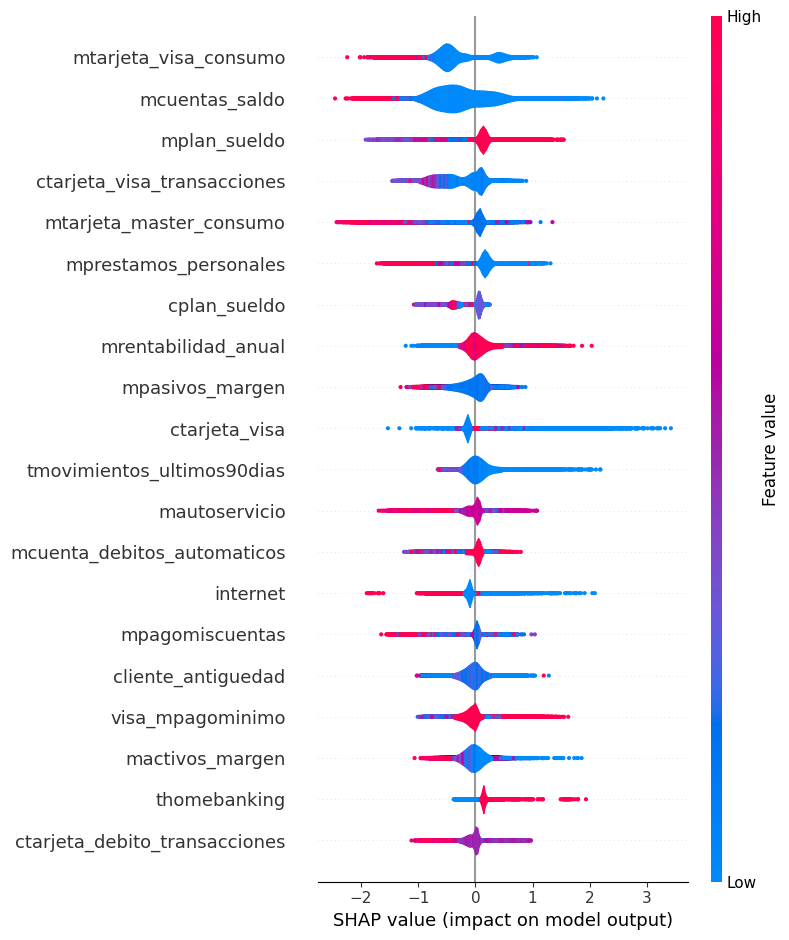

In [19]:
# Plot the summary plot (violin-style)
shap.summary_plot(shap_values, x, plot_type="violin")

I'll be identifying one true positive, one true negative, one false positive, and one false negative, by compareing the predictions of the model (y_pred) against the true labels (y). I'll use these values to display them in a waterfall plot.

In [20]:
y_prob = xg_boosting.predict_proba(x)[:, 1]  # Probability of the positive class
y_pred = xg_boosting.predict(x)             # Predicted class labels

In [21]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y, y_pred)

# Print the confusion matrix with labels
print("Confusion Matrix:")
print(f"                Predicted No   Predicted Yes")
print(f"Actual No     TN = {conf_matrix[0, 0]}    FP = {conf_matrix[0, 1]}")
print(f"Actual Yes    FN = {conf_matrix[1, 0]}    TP = {conf_matrix[1, 1]}")


Confusion Matrix:
                Predicted No   Predicted Yes
Actual No     TN = 168842    FP = 45
Actual Yes    FN = 691    TP = 1144


In [22]:
# Convert 'y' and 'y_pred' to a DataFrame for filtering
import pandas as pd

results_df = pd.DataFrame({
    "true_label": y,
    "predicted_label": y_pred,
    "probability": y_prob
})

# Identify cases
true_positive = results_df[(results_df["true_label"] == 1) & (results_df["predicted_label"] == 1)].iloc[0]
true_negative = results_df[(results_df["true_label"] == 0) & (results_df["predicted_label"] == 0)].iloc[0]
false_positive = results_df[(results_df["true_label"] == 0) & (results_df["predicted_label"] == 1)].iloc[0]
false_negative = results_df[(results_df["true_label"] == 1) & (results_df["predicted_label"] == 0)].iloc[0]

print("True Positive:", true_positive)
print("True Negative:", true_negative)
print("False Positive:", false_positive)
print("False Negative:", false_negative)


True Positive: true_label         1.000000
predicted_label    1.000000
probability        0.527972
Name: 317, dtype: float64
True Negative: true_label         0.000000
predicted_label    0.000000
probability        0.000409
Name: 0, dtype: float64
False Positive: true_label         0.000000
predicted_label    1.000000
probability        0.708994
Name: 11216, dtype: float64
False Negative: true_label         1.000000
predicted_label    0.000000
probability        0.150404
Name: 395, dtype: float64


In [23]:
# Get the row indices
tp_index = true_positive.name
tn_index = true_negative.name
fp_index = false_positive.name
fn_index = false_negative.name

In [24]:
print("Churn: 1 - No churn: 0")
print(f"True positive - real: {y.iloc[tp_index]}, prediction: {y_pred[tp_index]}")
print(f"True negative - real: {y.iloc[tn_index]}, prediction: {y_pred[tn_index]}")
print(f"False positive - real: {y.iloc[fp_index]}, prediction: {y_pred[fp_index]}")
print(f"False negative - real: {y.iloc[fn_index]}, prediction: {y_pred[fn_index]}")

Churn: 1 - No churn: 0
True positive - real: 1, prediction: 1
True negative - real: 0, prediction: 0
False positive - real: 0, prediction: 1
False negative - real: 1, prediction: 0


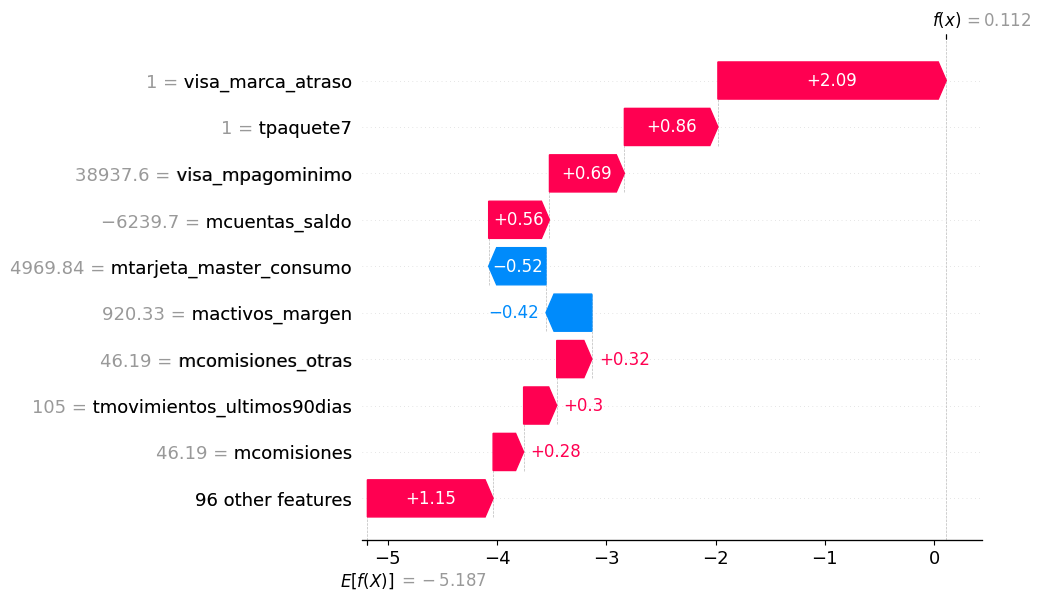

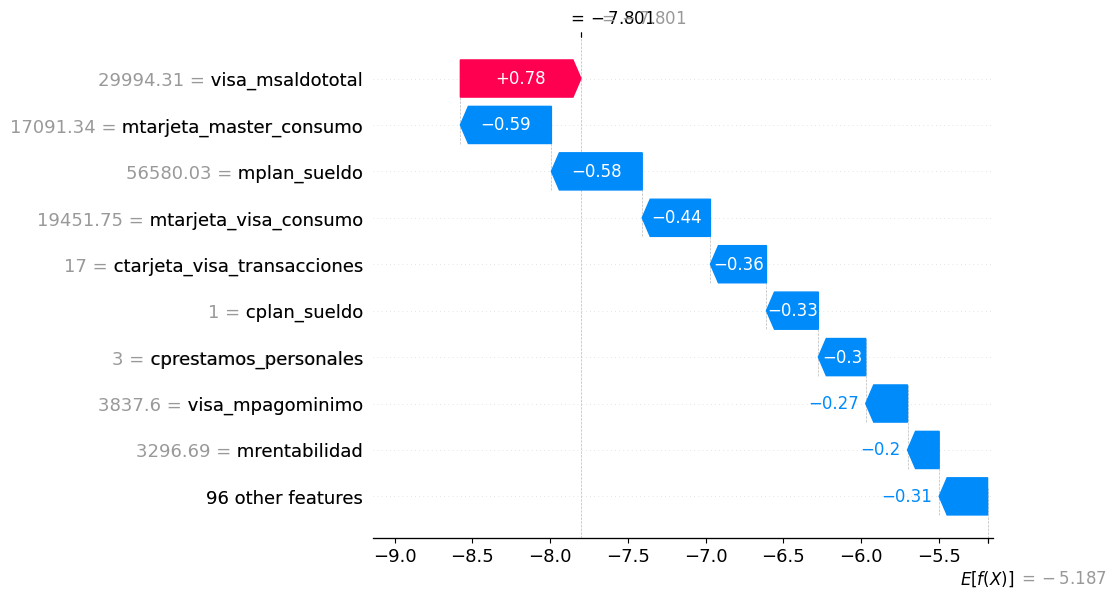

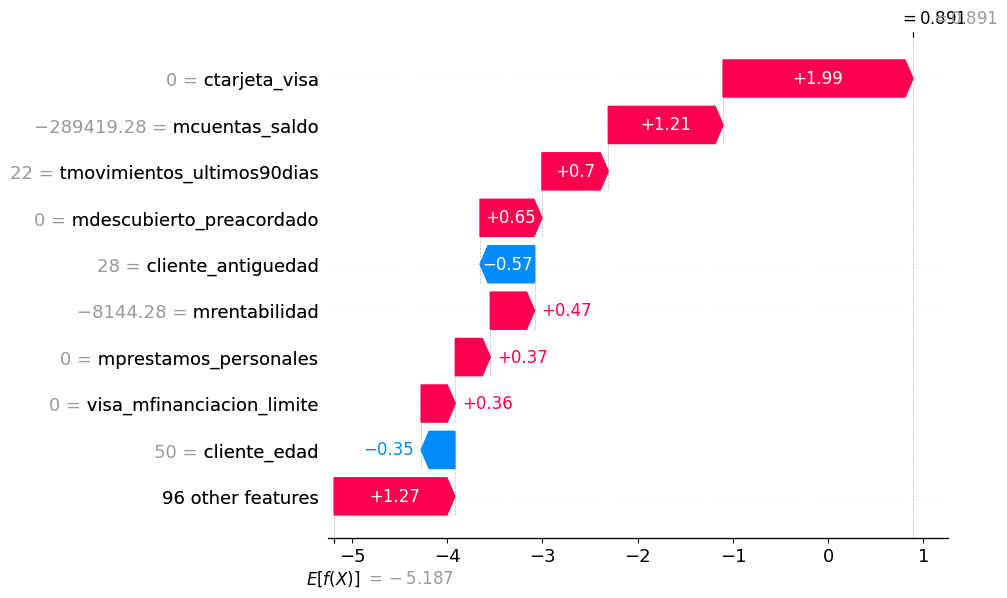

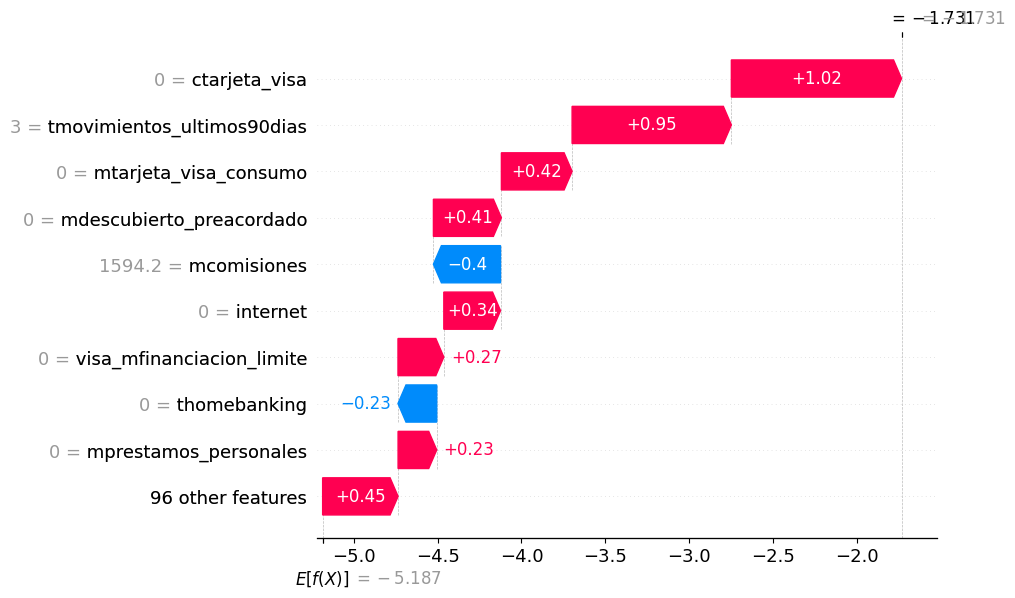

In [26]:
# Generate SHAP values for the entire dataset
shap_values = explainer(x)

# Plot waterfall plots for each case
shap.waterfall_plot(shap_values[tp_index], show=True, max_display=10)
shap.waterfall_plot(shap_values[tn_index], show=True, max_display=10)
shap.waterfall_plot(shap_values[fp_index], show=True, max_display=10)
shap.waterfall_plot(shap_values[fn_index], show=True, max_display=10)


I want to understand in more depth why my model has false negative, so I'll be waterfall plotting 10 additional cases of false negatives.

100%|===================| 170430/170722 [06:28<00:00]        

Waterfall plot for false negative at index: 395


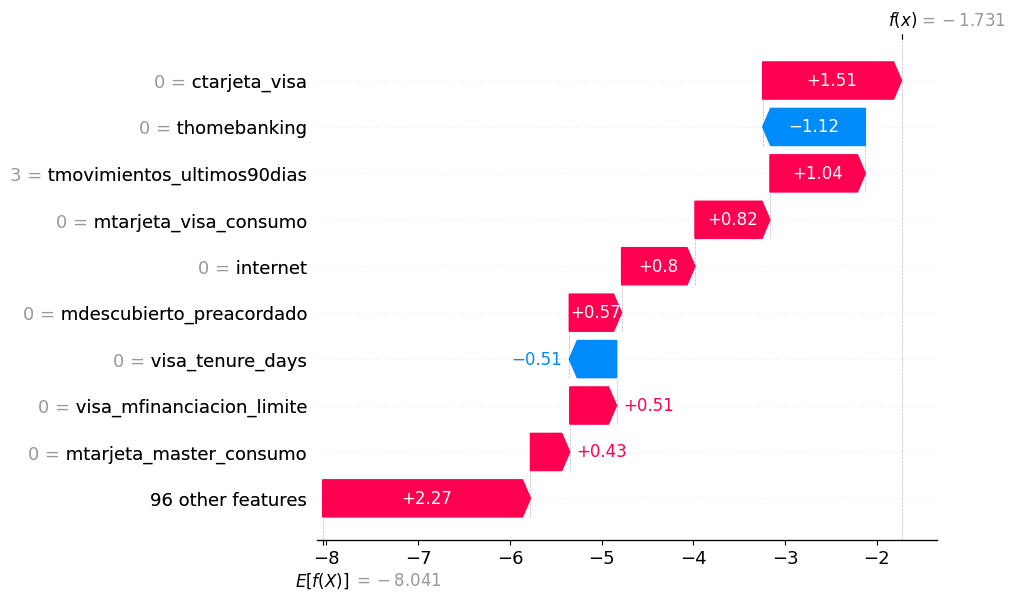

Waterfall plot for false negative at index: 1348


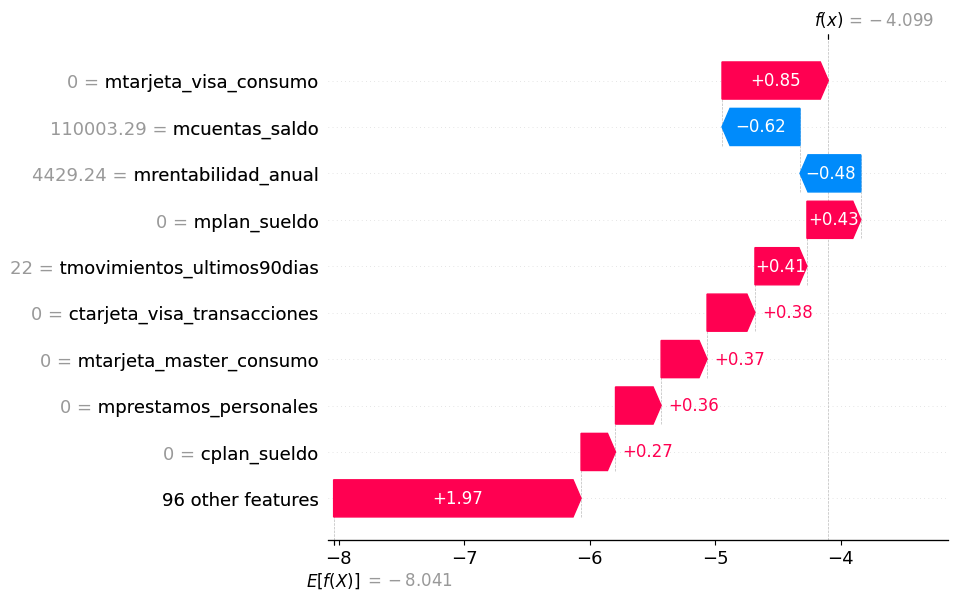

Waterfall plot for false negative at index: 2133


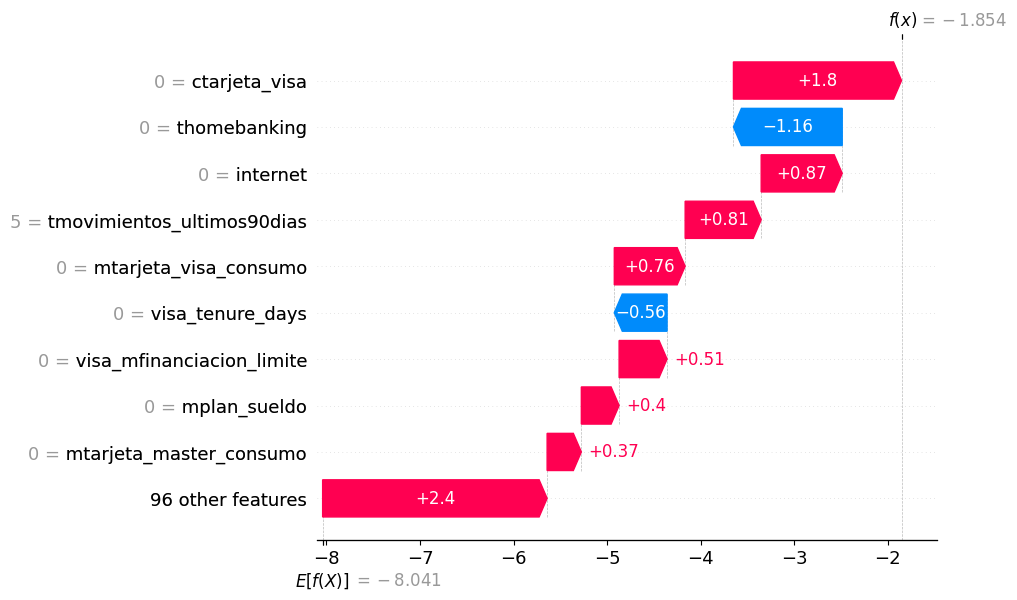

Waterfall plot for false negative at index: 2208


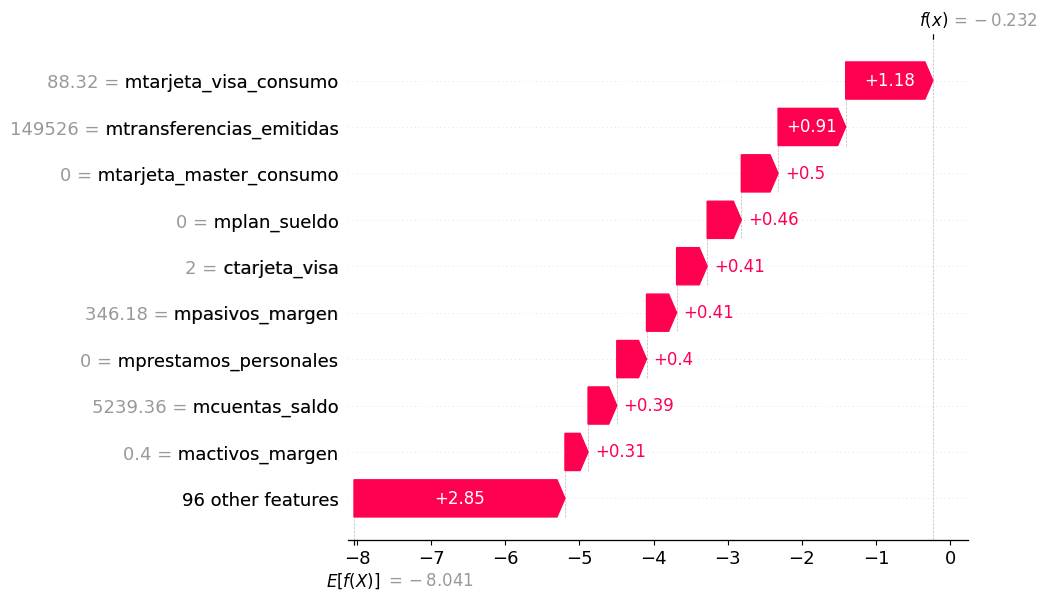

Waterfall plot for false negative at index: 2458


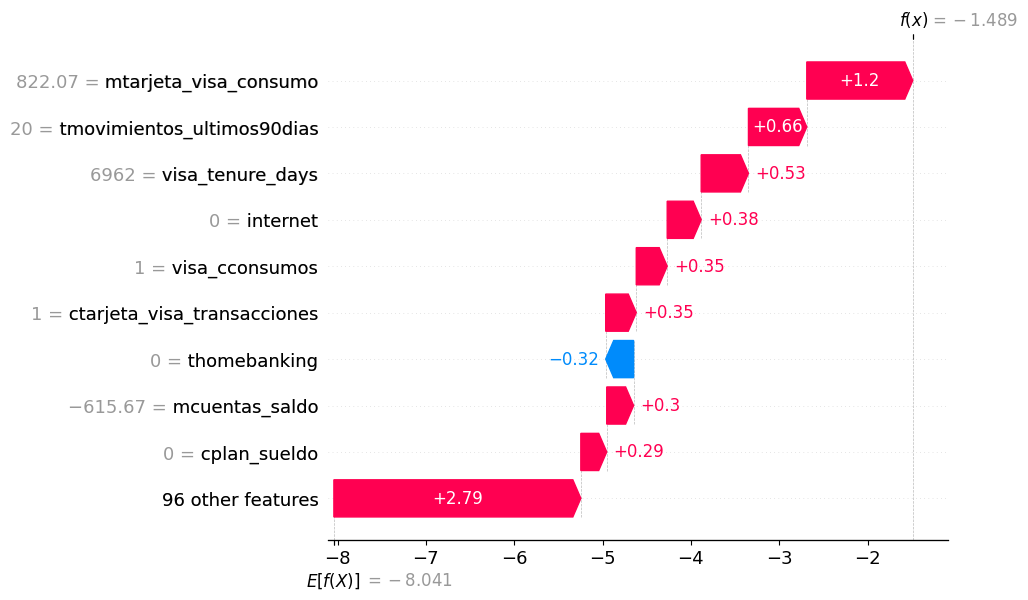

Waterfall plot for false negative at index: 3103


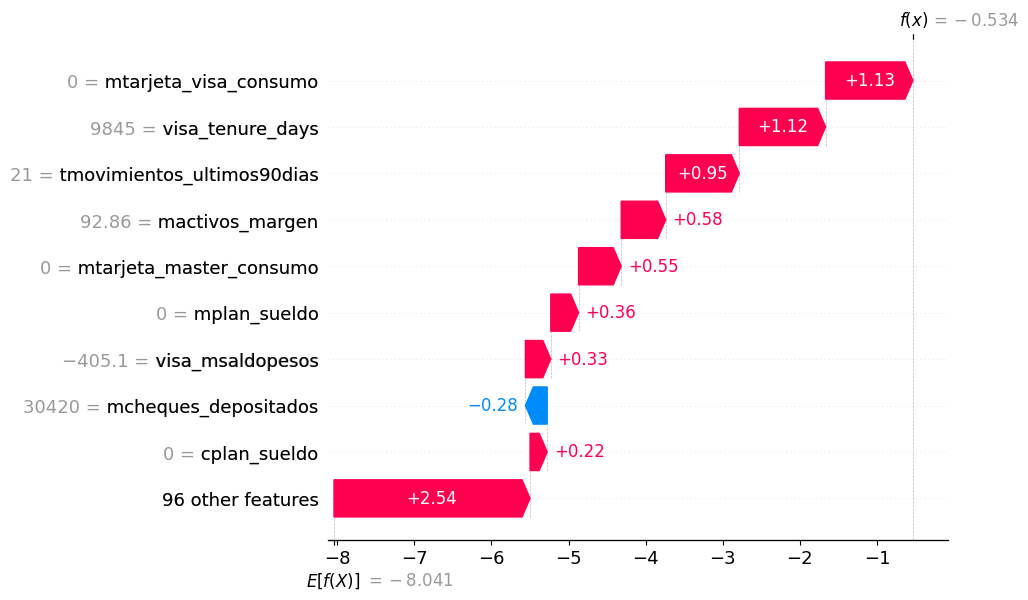

Waterfall plot for false negative at index: 3726


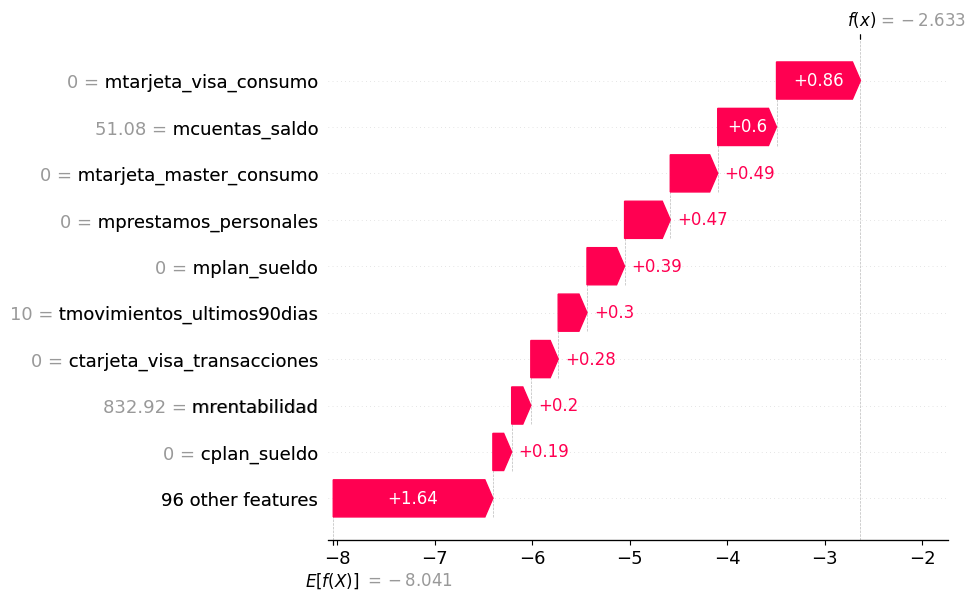

Waterfall plot for false negative at index: 3912


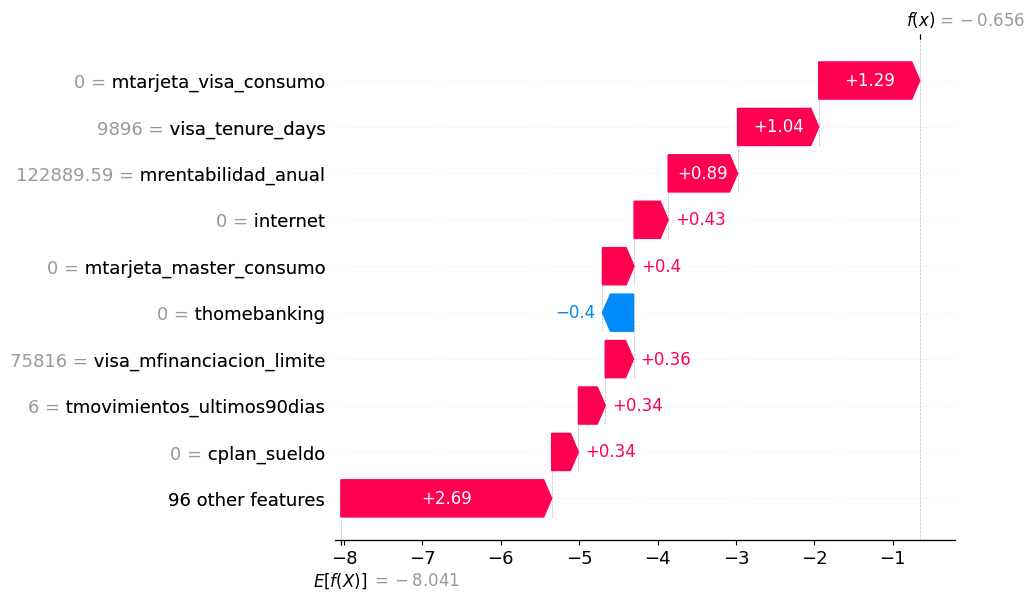

Waterfall plot for false negative at index: 3987


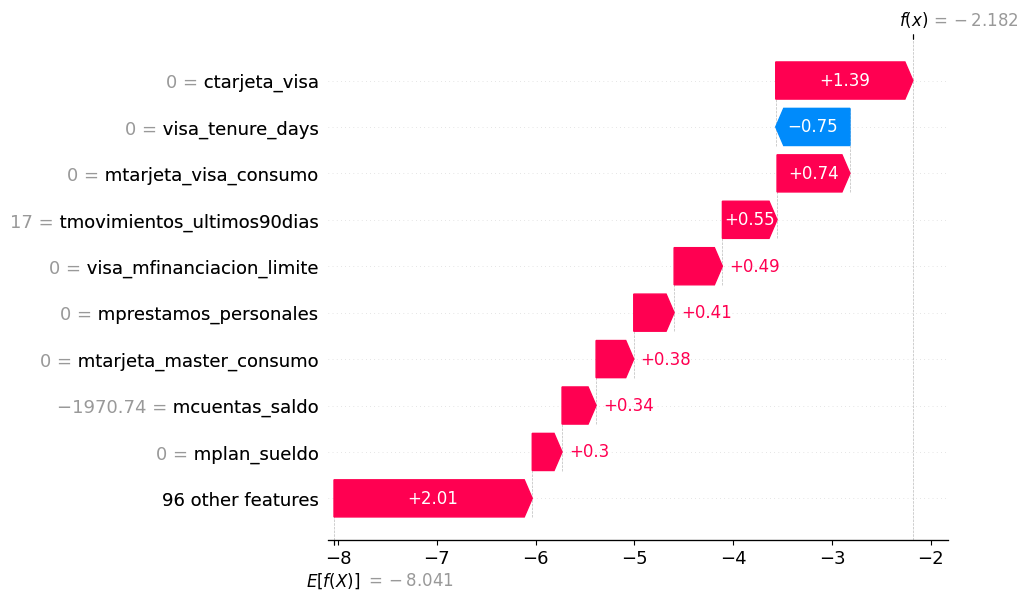

Waterfall plot for false negative at index: 4457


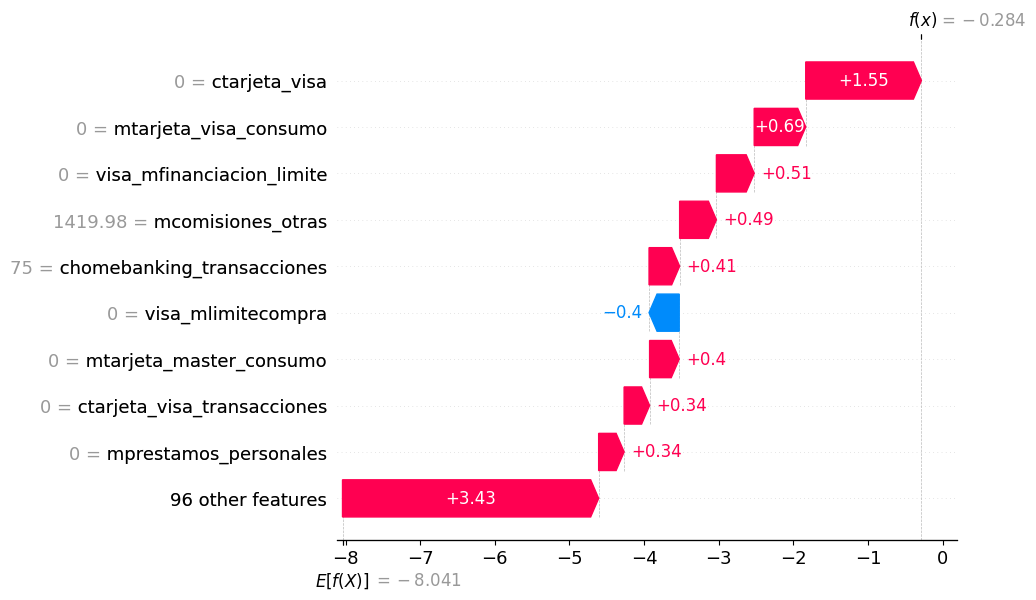

In [27]:
import shap

# Ensure you have the indices of false negatives
false_negatives_indices = np.where((y == 1) & (y_pred == 0))[0][:10]  # Adjust this if you already have `selected_fn_indices`

# Create the SHAP explainer for your trained model
explainer = shap.Explainer(xg_boosting, x)  # Ensure `xg_boosting` and `X` are defined
shap_values = explainer(x)  # Calculate SHAP values for the entire dataset

# Loop through each false negative and plot the waterfall
for idx in false_negatives_indices:
    print(f"Waterfall plot for false negative at index: {idx}")
    shap.waterfall_plot(shap_values[idx], max_display=10)  # Display top 10 features


# Model selection conclusion

XGBoost demonstrates the best performance among the base models in terms of AUC score, indicating its strong ability to distinguish between churn and non-churn cases. 

The most important features identified by the model align well with expectations for a churn prediction problem, providing confidence in the model's interpretability. However, the recall is relatively low, suggesting that the model is missing some churn cases. This issue could be addressed by optimizing hyperparameters to achieve a better balance between precision and recall, potentially improving recall without significantly compromising the AUC score.

Fine-tuning the model would enhance its ability to capture churners, making it more effective in real-world applications where identifying churn is critical.